In [48]:
import numpy as np
from matplotlib import pyplot as plt
import cv2

elev_file ="test_data/megt90n000fb.img"
dust_file = "test_data/dci_lo_ice_dust_16ppd_shifted.raw"
TI_file = "test_data/ti16"
alb_file = "test_data/alb32"



In [76]:
#OFFICIAL resolution: (2880, 5760)
def load_elevation(file):
    with open(file,"rb") as f:
        dat = f.read()
        z=np.frombuffer(dat, dtype='>i2').reshape(720*8,1440*8).astype(np.float64)
        
    return z

def load_dci(file):
    with open(file,"rb") as f:
        dat = f.read()
    dci = np.frombuffer(dat,dtype=np.float32).reshape(2880,5760)
    return dci

def load_TI(file, VICAR_LBLSIZE=11520):
    with open(file,"rb") as f:
        dat = f.read()
    ti = np.frombuffer(dat[VICAR_LBLSIZE:], dtype=np.float32).reshape(1440,2880)
    return ti

def load_alb(file, VICAR_LBLSIZE=11520):
    with open(file,"rb") as f:
        dat = f.read()
    alb = np.frombuffer(dat[VICAR_LBLSIZE:], dtype=np.float32).reshape(1440,2880)
    return alb

def roll_dci(dci, ROLL=2880):
    return np.roll(dci, ROLL, axis=1)


def downsample_elevation(elev):
    return elev[0::2,0::2]


def scale_up(arr):
    # Nearest Neighbor interpolation
    new_arr = np.zeros((2880, 5760))
    
    new_arr[0::2,0::2] = arr
    new_arr[1::2,0::2] = arr
    new_arr[0::2,1::2] = arr
    new_arr[1::2,1::2] = arr
    
    return new_arr


# Load Files
elev = load_elevation(elev_file)
dci = load_dci(dust_file)
ti = load_TI(TI_file)
alb = load_alb(alb_file)

# Pre Process
elev = downsample_elevation(elev)
dci = roll_dci(dci)
ti = scale_up(ti)
alb = scale_up(alb)

assert elev.shape == dci.shape == ti.shape == alb.shape

(2880, 5760)

In [52]:
elev[0::2,0::2].shape

(2880, 5760)

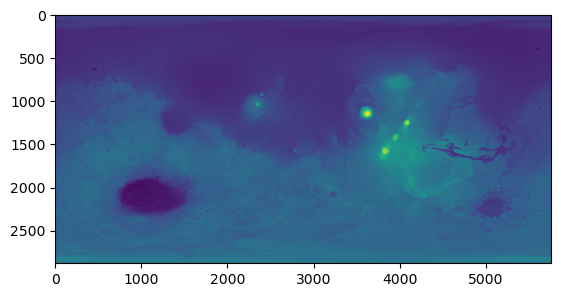

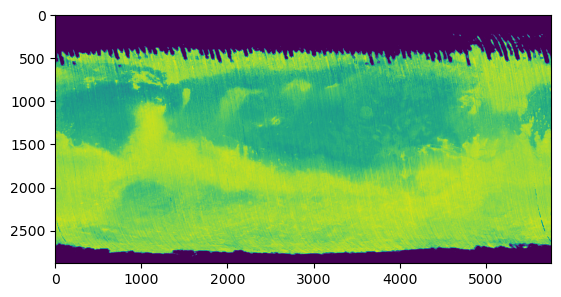

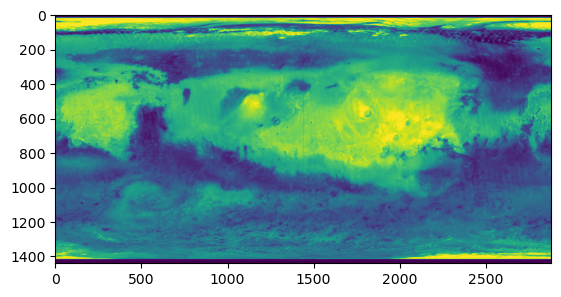

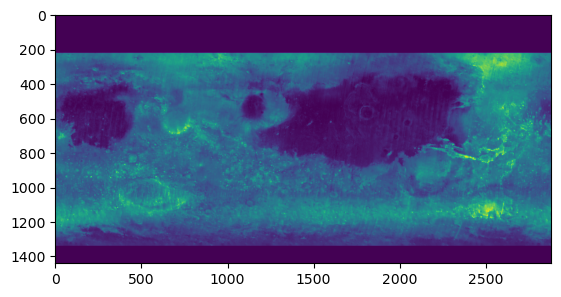

In [51]:
plt.imshow(elev[0::2,0::2])
plt.show()
plt.imshow(dci)
plt.show()
plt.imshow(alb)
plt.show()
plt.imshow(ti)
plt.show()

In [12]:
elev<0

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

np.frombuffer(dat).reshape(5760,2880)

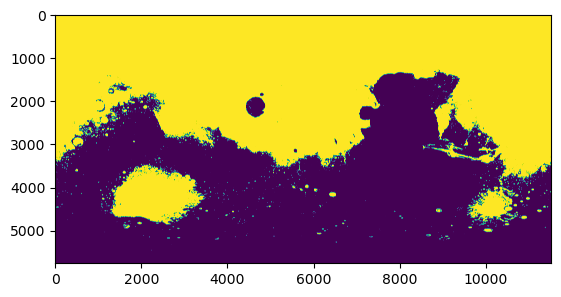

In [43]:
33177600/5760

5760.0